# LSTM with Tensorflow 

* [RECURRENT NEURAL NETWORK REGULARIZATION](https://arxiv.org/pdf/1409.2329.pdf) - TensorFlow BasicLSTMCell에 사용된 논문
* [Simple Implementation of LSTM in Tensorflow in 50 lines](https://gist.github.com/nivwusquorum/b18ce332bde37e156034e5d3f60f8a23)
* [LSTM Cell to learn zero](https://gist.github.com/nivwusquorum/160d5cf7e1e82c21fad3ebf04f039317)





* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [2003 Tutorial on LSTM Recurrent Nets](http://people.idsia.ch/~juergen/lstm2003tutorial.pdf)
* [LSTM Recurrent Networks Learn Simple Context Free and Context Sensitive Languages](ftp://ftp.idsia.ch/pub/juergen/L-IEEE.pdf)
* [LSTM: A Search Space Odyssey](https://arxiv.org/pdf/1503.04069.pdf)

In [1]:
%pylab inline
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.contrib.rnn import RNNCell, BasicLSTMCell, MultiRNNCell, DropoutWrapper
from tensorflow.examples.tutorials.mnist import input_data
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


### Data

Train X: (98, 1, 1)
Train Y: (98, 1, 1)
Test X: (42, 1, 1)
Test Y: (42, 1, 1)


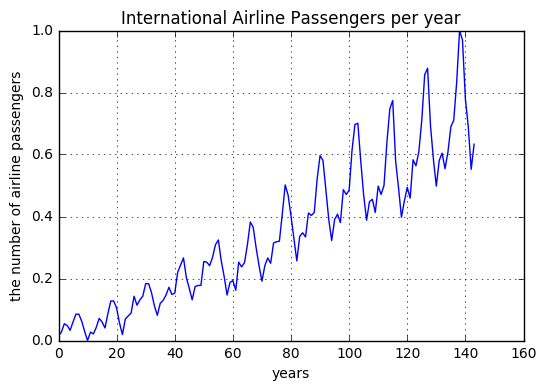

In [2]:
# Load Data
data = pd.read_csv('../../data/time-series/international-airline-passengers.csv', 
                   names=['passenger'],
                   skiprows=1, usecols=[1])

# Normalize Data using Min-Max Scaler 
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data = data.astype('float32')

# Seperate Train and Test Data
_size = int(len(data) * 0.7) # 144
train, test = data[:_size], data[_size:] # 100, 44

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i])
        dataY.append(dataset[i+1])
    return np.array(dataX), np.array(dataY)

def reshape(dataset):
    return np.reshape(dataset, (dataset.shape[0], 1, dataset.shape[1]))

look_back = 1
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

train_x = reshape(train_x)
train_y = reshape(train_y)
test_x = reshape(test_x)
test_y = reshape(test_y) 

print('Train X:', train_x.shape)
print('Train Y:', train_y.shape)
print('Test X:', test_x.shape)
print('Test Y:', test_y.shape)

title('International Airline Passengers per year')
ylabel('the number of airline passengers')
xlabel('years')
grid()
plot(data)

### Model

In [3]:
hidden_size = 5

with tf.variable_scope('test' + str(np.random.randint(0, 100000))):
    inputs = tf.placeholder('float32', shape=[None, None, 1], name='inputs') # [batch, time, in]
    targets = tf.placeholder('float32', shape=[None, None, 1], name='targets') # [batch, time, out]
    
    cell = BasicLSTMCell(hidden_size, forget_bias=1.0, state_is_tuple=True)
#     cell = DropoutWrapper(cell)
    state = cell.zero_state(1, 'float32')

    rnn_outputs, rnn_states = tf.nn.dynamic_rnn(cell, inputs, initial_state=state, time_major=True)
    rnn_outputs = tf.reshape(rnn_outputs, [-1, hidden_size])
    
    w = tf.get_variable('weights', [hidden_size, 1], initializer=tf.random_normal_initializer())
    b = tf.get_variable('biases', [1, 1], initializer=tf.constant_initializer())
    
    dense1 = tf.matmul(rnn_outputs, w) + b
    dense2 = tf.reduce_sum(dense1, reduction_indices=[1])
    prediction = tf.nn.sigmoid(dense2)
    
    error2 = tf.square(targets - prediction)
    error3 = tf.reduce_mean(error2, reduction_indices=[1, 2])
    train_fn = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error3)

### Initialize Tensorflow Session and Variables

In [4]:
init_op = tf.global_variables_initializer()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.001, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init_op)

### Train

[100]Training Cost: 0.001866 	Test Cost:0.034277걸린시각:17.954605 초


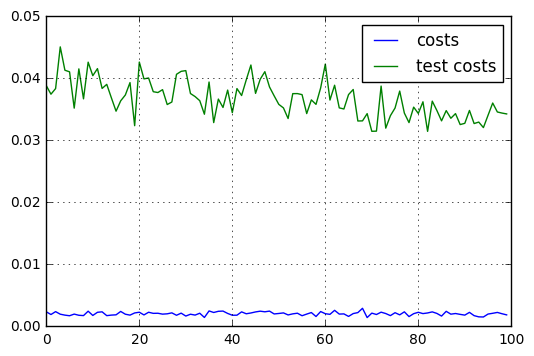

In [8]:
def train(x, y, test_x, test_y, epoch=100, train_less=0.0019, test_less=0.03):
    now = datetime.now()
    N = len(x)
    g_costs = []
    g_test_costs = []
    for global_step in range(epoch):
        costs = []
        
        # Shuffle
        permu = np.random.permutation(x.shape[0])
        x = x[permu]
        y = y[permu]
        
        for _ in range(N):
            i = np.random.randint(0, N)
            sample_x = x[i: i+1]
            sample_y = y[i: i+1]

            cost, _ = sess.run([error3, train_fn], feed_dict={inputs: sample_x, targets: sample_y})
            costs.append(np.sum(cost))
        
        # Evaluate Training cost
        _c = np.sum(costs)/len(costs)
        g_costs.append(_c)
        
        # Evaluate Test Cost
        test_predicted = sess.run(error3, feed_dict={inputs: test_x, targets: test_y})
        test_cost = np.sum(test_predicted)/len(test_predicted)
        g_test_costs.append(test_cost)
        
        print('\r[%d]Training Cost: %.6f \tTest Cost:%.6f' % (global_step + 1, _c, test_cost), end='')
        if test_less > test_cost and train_less > _c:
            break
    
    
    seconds = (datetime.now() - now).total_seconds()
    return seconds, g_costs, g_test_costs

seconds, costs, test_costs = train(train_x, train_y, test_x, test_y)
print('걸린시각:%s 초'% seconds)
plot(costs, label='costs')
plot(test_costs, label='test costs')
grid()
legend()

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


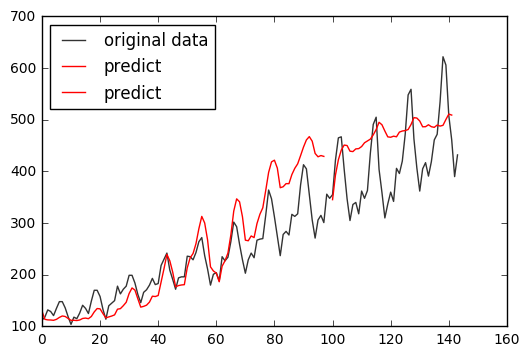

In [9]:
train_predicted = sess.run(prediction, feed_dict={inputs: train_x})
test_predicted = sess.run(prediction, feed_dict={inputs: test_x})

train_predicted = scaler.inverse_transform(train_predicted.reshape(train_predicted.shape[0]))
test_predicted =  scaler.inverse_transform(test_predicted.reshape(test_predicted.shape[0]))

plot_train_x = np.arange(0, train_predicted.shape[0])
plot_test_x = np.arange(plot_train_x.shape[0] + 2, plot_train_x.shape[0] + test_predicted.shape[0] + 2)

plot(scaler.inverse_transform(data), color='#333333', label='original data')
plot(plot_train_x, train_predicted, plot_test_x, test_predicted, color='red', label='predict')

legend(loc='upper left')